# <a id='toc1_'></a>[Convolutional Neural Network for Anime Image Classification](#toc0_)


**Table of contents**<a id='toc0_'></a>    
- [Convolutional Neural Network for Anime Image Classification](#toc1_)    
  - [Objectives](#toc1_1_)    
  - [Setup](#toc1_2_)    
    - [Installing Required Libraries](#toc1_2_1_)    
    - [Importing Required Libraries](#toc1_2_2_)    
  - [Load the Data](#toc1_3_)    
    - [Visualize the Dataset](#toc1_3_1_)    
  - [Define Custom Dataset Class](#toc1_4_)    
  - [Split Dataset into Training and Validation Sets](#toc1_5_)    
  - [Define the CNN Model](#toc1_6_)    
  - [Define Loss Function and Optimizer](#toc1_7_)    
  - [Train the Model](#toc1_8_)    
  - [Visualize the Training and Test Loss](#toc1_9_)    
  - [Exercises](#toc1_10_)    
    - [Exercise 1 - Change activation function to `leaky_relu`](#toc1_10_1_)    
    - [Exercise 2 - Increase the number of epochs and observe the training and validation loss](#toc1_10_2_)    
    - [Exercise 3 - Use different character classes for training and validation](#toc1_10_3_)    
  - [Authors](#toc1_11_)    
  - [Contributors](#toc1_12_)    


In [23]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
from torchvision import transforms

from pathlib import Path
from PIL import Image
import random

plt.style.use("dark_background")

In [10]:
dataset_dir = Path("data/")
anastasia, takao = classes = ['anastasia', 'takao']
label_encode = {anastasia: 0, takao: 1}
label_decode = {0: anastasia, 1: takao}

anastasia_files = list((dataset_dir / anastasia).glob("*.jpg"))
takao_files = list((dataset_dir / takao).glob("*.jpg"))

In [11]:
len(anastasia_files), len(takao_files)

(50, 50)

In [12]:
sample_image = Image.open(anastasia_files[0]).convert("RGB")

sample_image.size

(96, 96)

In [14]:
class AnimeDataset(Dataset):
    def __init__(self, anastasia_files, takao_files, transform=None):
        self.file_paths = anastasia_files + takao_files
        self.anastasia_files = anastasia_files
        self.takao_files = takao_files
        self.labels = [0] * len(anastasia_files) + [1] * len(takao_files)
        self.transform = transform

    def show_image(self, idx):
        image_path = self.file_paths[idx]
        image = Image.open(image_path).convert("RGB")
        label = self.labels[idx]
        plt.imshow(image)
        plt.title(f"Label: {label_decode[label]}")
        plt.axis('off')
        plt.show()
    
    def show_class_images(self, num_images=5):
        anastasia_images = random.sample(self.anastasia_files, num_images)
        takao_images = random.sample(self.takao_files, num_images)
        
        fig, axes = plt.subplots(2, num_images, figsize=(15, 6))
        for i, img_path in enumerate(anastasia_images):
            image = Image.open(img_path).convert("RGB")
            axes[0, i].imshow(image)
            axes[0, i].set_title("Anastasia")
            axes[0, i].axis('off')
        for i, img_path in enumerate(takao_images):
            image = Image.open(img_path).convert("RGB")
            axes[1, i].imshow(image)
            axes[1, i].set_title("Takao")
            axes[1, i].axis('off')
        plt.show()
    
    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        image_path = self.file_paths[idx]
        image = Image.open(str(image_path)).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [15]:
train_size = 0.7
random_state = 42

train_anastasia, val_anastasia = train_test_split(anastasia_files, train_size=train_size, random_state=random_state)
train_takao, val_takao = train_test_split(takao_files, train_size=train_size, random_state=random_state)

In [16]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

train_dataset = AnimeDataset(train_anastasia, train_takao, transform=transform)
val_dataset = AnimeDataset(val_anastasia, val_takao, transform=transform)

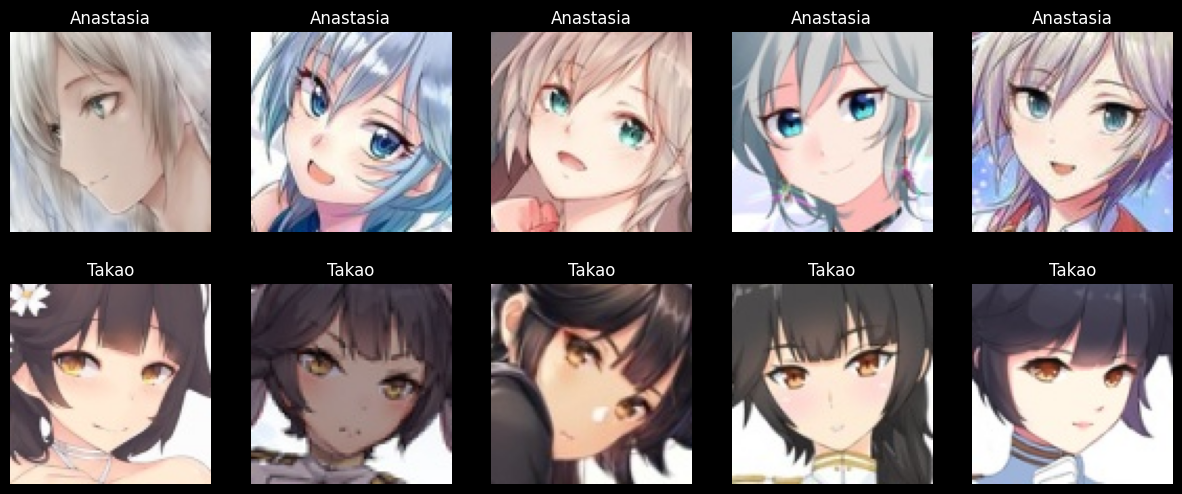

In [17]:
train_dataset.show_class_images()

In [18]:
len(train_dataset), len(val_dataset)

(70, 30)

In [49]:
class AnimeClassifier(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.model = nn.Sequential(
            nn.Conv2d(in_channels, 3, kernel_size=(5, 5)),
            nn.ReLU(),
            nn.MaxPool2d((5, 5)),
            nn.Flatten(),
            nn.Linear(3 * 12 * 12, num_classes),
        )
    
    def forward(self, X):
        return self.model(X)
    
    def predict(self, X):
        with torch.no_grad():
            return torch.softmax(self.forward(X), 1)

In [20]:
(64 - 5 + 1) / 5

12.0

In [61]:
anime_classifier = AnimeClassifier(3, len(classes))

batch_size = 10
train_loader = DataLoader(train_dataset, batch_size=batch_size)
val_loader = DataLoader(val_dataset, batch_size=batch_size)